### Dependencies

In [80]:
def get_f_period(p_date,f_date):
    d = pd.to_datetime(p_date) - pd.to_datetime(f_date)
    return d.days * 24  + d.seconds // 3600

import os 
import pickle
import pandas as pd
import numpy as np
import xgboost
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

### Load Data 
- Last Measurements (from 01/03/2021)
- Last 5 months of Forecasts

In [2]:
# Measurements
measurement_out = pd.read_csv('../data/processed/last_measurement.csv')
measurement_out['datetime'] = measurement_out['datetime'].map(lambda x : pd.to_datetime(x)) 
# Forecasts
forecast = pd.read_csv('../data/processed/last_forecast.csv')
forecast['f_date'] = forecast['f_date'].map(lambda x : pd.to_datetime(x))
forecast['p_date'] = forecast['p_date'].map(lambda x : pd.to_datetime(x))
forecast['file_creation_date'] = forecast['file_creation_date'].map(lambda x : pd.to_datetime(x))

### Data Processing
- Shift measurements to get 49 lag
- Data Merge 
- Keep last forecasts

In [3]:
### Data Merge ###

# Save a copy of measurements to score results
Y_real = measurement_out.copy()

# 49 lag of measurements horizontal stack 
df_out = Y_real.add_suffix('_t-0')
for i in range(1, 49):
    df_temp = Y_real.copy().add_suffix('_t-'+str(i))
    df_out = pd.concat([df_out,df_temp.shift(i)],axis=1)
df_out = df_out.dropna(how='any')
#display(df_out.head(1))

# join measurements & forecast
df_joined = df_out.copy()
df_joined = df_joined.merge(forecast.add_suffix('_forecast'),
                 how='left',
                 left_on = 'datetime_t-0',
                 right_on='f_date_forecast')

# filter forecast files created after prediction time (same as crop out f_period > 7)
df_joined = df_joined.loc[df_joined['datetime_t-0'] >= df_joined['file_creation_date_forecast'],]


# Compute f_period
df_joined['f_period'] = df_joined[['datetime_t-0','p_date_forecast']] \
                         .apply(lambda row : get_f_period(row['datetime_t-0'],row['p_date_forecast']),axis=1)

# assert that file_creation_date_forecast is doing the job
assert((df_joined.f_period > 7).any()) 

# keep last forecast
df_joined = df_joined.groupby('datetime_t-0')['f_period'].min().reset_index() \
             .merge(df_joined,how='left')
    
# compute cos day and hour 
df_joined['cos_day'] = np.cos(2 * np.pi * df_joined['datetime_t-0'].dt.day / 365)
df_joined['cos_hour'] =  np.cos(2 * np.pi * df_joined['datetime_t-0'].dt.hour / 24)
#display(df_joined.head(1))

### New models adjustements
- Compute forecast scenario & Dangerous
- Rename f_period -> f_period_forecast

In [4]:
# Compute needed columns for updated models
def get_int_scenario(speed, cos, sin):
    if is_S1(speed, cos, sin):
        return 1
    elif is_S2(speed, cos, sin):
        return 2
    elif is_S2b(speed, cos, sin):
        return 3
    elif is_S3(speed, cos, sin):
        return 4
    elif is_S3b(speed, cos, sin):
        return 5
    elif is_S4(speed, cos, sin):
        return 6
    return np.nan

import sys
sys.path.append('../')
from utils.ui import *

df_joined['scenario_forecast'] = df_joined.apply(lambda row : get_int_scenario(row['speed_forecast'],
                                             row['cos_wind_dir_forecast'],
                                             row['sin_wind_dir_forecast']),
                  axis=1)

df_joined['dangerous_forecast'] = (df_joined['scenario_forecast'] > 3 ).map(int)

df_joined = df_joined.rename(columns={'f_period':'f_period_forecast'})

### Make predictions
- Load all models (regression & classification
- Merge predictions : model_feature_lag (prediction date is shifted to align with measurement t-0)

In [5]:
# To render results on app we need a branch here for datetime shift ###
from datetime import timedelta

# Load needed columns for all models 
columns_names = list(pd.read_csv('../models_09072021/column_names.csv')['0'])

# Loop lists
model_names = ['xgb','dt','mlp','rf']
features = ['speed','cos_wind_dir','sin_wind_dir','scenario','dangerous']
pred_periods = ['1','2','3']


models = dict()
for model_name in model_names:
    for feature in features:
        for pred_period in pred_periods:
            x = '_'.join([model_name,feature,pred_period])
            # Load model
            models[x] = pickle.load(open('../models_09072021/trained_models/' + x + '.pkl','rb'))
            df_temp = df_joined[['datetime_t-0']].copy()
            # Shift date
            df_temp['datetime_t-0'] = df_temp['datetime_t-0'] + timedelta(hours=int(pred_period))
            # Predict
            try:
                assert(feature == 'dangerous')
                df_temp[x] = models[x].predict_proba(df_joined[columns_names])[:,1]
                print(x)
            except:
                df_temp[x] = models[x].predict(df_joined[columns_names])
            # Save
            df_joined = df_joined.merge(df_temp,how='left')
            del df_temp

# Drop missing values (at least the 3 first rows)
df_joined = df_joined.dropna()
df_joined.shape

xgb_dangerous_1
xgb_dangerous_2
xgb_dangerous_3
dt_dangerous_1
dt_dangerous_2
dt_dangerous_3
mlp_dangerous_1
mlp_dangerous_2
mlp_dangerous_3
rf_dangerous_1
rf_dangerous_2
rf_dangerous_3


(3451, 467)

(array([3.118e+03, 1.450e+02, 2.300e+01, 4.200e+01, 4.900e+01, 3.000e+00,
        9.000e+00, 2.700e+01, 1.900e+01, 1.600e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

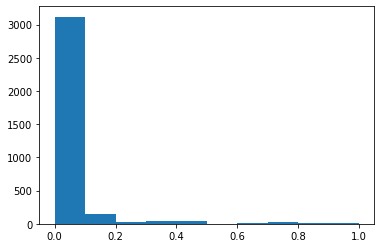

In [6]:
import matplotlib.pyplot as plt
plt.hist(df_joined['dt_dangerous_2'])

### Speed regression mae

In [7]:
from sklearn.metrics import mean_absolute_error

### Speed Mae ###
print('Model   1   2   3')
for model in ['xgb','rf','dt','mlp']:
    print(model,
          round(mean_absolute_error(df_joined['speed_t-0'],df_joined[model + '_speed_1']),2),
          round(mean_absolute_error(df_joined['speed_t-0'],df_joined[model + '_speed_2']),2),
          round(mean_absolute_error(df_joined['speed_t-0'],df_joined[model + '_speed_3']),2)
         )
print('Numtech' , round(mean_absolute_error(df_joined['speed_t-0'],df_joined['speed_forecast']),2))

Model   1   2   3
xgb 0.5 0.76 0.94
rf 0.54 0.83 1.04
dt 0.56 0.84 1.07
mlp 0.55 0.78 0.91
Numtech 1.04


### Wind Direction Regression Mae

In [8]:
def get_angle_in_degree(cos, sin):
    #check if cos within reasonable range: 
    if (cos>=-1) & (cos <=1): 
        angle = 360 * np.arccos(cos) / (2*np.pi)
        if sin < 0:
            angle = 360 - angle
    #check if sin within reasonable range:       
    elif (sin>=-1) & (sin <=1):
        angle = 360 * np.arcsin(sin) / (2*np.pi)
        if cos < 0:
            angle = 180 - angle
        if angle < 0:
            angle += 360
    else:
        angle=0 
        #print('cos and sin out of range, returned 0')
    #because we care about the reverse angle for the scenarios
    return angle #(angle + 180) % 360

def angle_diff(x):
    if x <= 180:
        return x 
    else:
        return 360-180
    

### Real wind dir ###
df_joined['wind_dir_t-0'] =  df_joined.apply(lambda row : get_angle_in_degree(row['cos_wind_dir_t-0'],
                                                                              row['sin_wind_dir_t-0']),
                                             axis=1)
    
for model_name in model_names:
    for pred_period in pred_periods:
        input_cos = model_name + '_cos_wind_dir_' + pred_period
        input_sin = model_name + '_sin_wind_dir_' + pred_period
        output_wind_dir = model_name + '_wind_dir_' + pred_period
        df_joined[output_wind_dir] =  df_joined.apply(lambda row : get_angle_in_degree(row[input_cos],row[input_sin]),axis=1)
        
print('Model  1  2  3')
for model_name in model_names:
    print(model_name,
          round((df_joined[model_name + '_wind_dir_1'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean()),
          round((df_joined[model_name + '_wind_dir_2'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean()),
          round((df_joined[model_name + '_wind_dir_3'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean())
         )
print("Numtech ",round((df_joined['wind_dir_forecast'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean()))

Model  1  2  3
xgb 17 27 38
dt 20 30 43
mlp 20 28 32
rf 19 29 39
Numtech  41


# For Karim: Ensemble Modeling

In [83]:
c_1 = [col for col in df_joined.columns if col[-2:]=='_1']+['speed_forecast','cos_wind_dir_forecast','sin_wind_dir_forecast','dangerous_forecast']
c_2 = [col for col in df_joined.columns if col[-2:]=='_2']+['speed_forecast','cos_wind_dir_forecast','sin_wind_dir_forecast','dangerous_forecast']
c_3 = [col for col in df_joined.columns if col[-2:]=='_3']+['speed_forecast','cos_wind_dir_forecast','sin_wind_dir_forecast','dangerous_forecast']

In [84]:
c_1

['xgb_speed_1',
 'xgb_cos_wind_dir_1',
 'xgb_sin_wind_dir_1',
 'xgb_scenario_1',
 'xgb_dangerous_1',
 'dt_speed_1',
 'dt_cos_wind_dir_1',
 'dt_sin_wind_dir_1',
 'dt_scenario_1',
 'dt_dangerous_1',
 'mlp_speed_1',
 'mlp_cos_wind_dir_1',
 'mlp_sin_wind_dir_1',
 'mlp_scenario_1',
 'mlp_dangerous_1',
 'rf_speed_1',
 'rf_cos_wind_dir_1',
 'rf_sin_wind_dir_1',
 'rf_scenario_1',
 'rf_dangerous_1',
 'speed_forecast',
 'cos_wind_dir_forecast',
 'sin_wind_dir_forecast',
 'dangerous_forecast']

In [39]:
df_joined[c]

,xgb_speed_2,xgb_cos_wind_dir_2,xgb_sin_wind_dir_2,xgb_scenario_2,xgb_dangerous_2,dt_speed_2,dt_cos_wind_dir_2,dt_sin_wind_dir_2,dt_scenario_2,dt_dangerous_2,...,mlp_dangerous_2,rf_speed_2,rf_cos_wind_dir_2,rf_sin_wind_dir_2,rf_scenario_2,rf_dangerous_2,speed_forecast,cos_wind_dir_forecast,sin_wind_dir_forecast,dangerous_forecast
3,2.804734,-0.338507,-0.509131,2.0,0.029789,2.261564,-0.129181,-0.114241,2.0,0.139676,...,5.261265e-01,2.691144,-0.326631,-0.592034,2.0,0.096653,1.9,-0.500000,-0.866025,0
4,2.627531,-0.371058,-0.593188,2.0,0.021820,2.742150,-0.401341,0.111571,2.0,0.139676,...,3.003663e-05,2.742210,-0.361463,-0.768567,2.0,0.096951,2.4,-0.731354,-0.681998,0
5,3.048049,-0.430985,-0.747240,2.0,0.048950,3.001659,-0.401341,-0.699060,2.0,0.139676,...,1.488893e-06,3.189404,-0.436628,-0.742995,2.0,0.097860,2.8,-0.809017,-0.587785,0
6,3.196791,-0.590176,-0.687618,2.0,0.032284,3.301085,-0.663833,-0.699060,2.0,0.020202,...,2.481934e-06,3.249508,-0.562221,-0.644429,2.0,0.081565,3.4,-0.819152,-0.573576,0
7,4.340111,-0.487167,-0.748384,1.0,0.015276,4.870745,-0.504535,-0.860539,1.0,0.020202,...,1.079425e-04,4.601542,-0.386943,-0.875303,2.0,0.069977,3.4,-0.681998,-0.731354,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3455,3.557292,0.754561,0.224757,1.0,0.007108,3.284760,0.799339,0.152143,1.0,0.023273,...,7.357441e-15,3.321728,0.762344,0.503375,1.0,0.028882,3.6,0.999848,-0.017452,0
3456,3.944977,0.749420,-0.113387,1.0,0.001623,3.729428,0.654498,0.152143,1.0,0.023273,...,3.241089e-17,3.442487,0.705969,0.299204,1.0,0.027878,4.2,0.992546,-0.121869,0
3457,5.048553,0.809669,-0.472081,1.0,0.000405,3.729428,0.799588,-0.458969,1.0,0.002027,...,6.242179e-20,4.677290,0.801887,-0.269236,1.0,0.024808,4.9,0.987688,-0.156434,0
3458,5.991407,0.803811,-0.634122,1.0,0.000123,5.169125,0.799588,-0.579512,1.0,0.002027,...,1.863772e-21,4.977888,0.825581,-0.542153,1.0,0.022564,5.4,0.994522,-0.104528,0


In [41]:
# Real scenario & dangerous #
df_joined['scenario_t-0'] = df_joined.apply(lambda row : get_int_scenario(row['speed_t-0'],
                                                                          row['cos_wind_dir_t-0'],
                                                                          row['sin_wind_dir_t-0']),
                                                    axis=1)
df_joined['dangerous_t-0'] = (df_joined['scenario_t-0'] > 3).map(int)

In [85]:
X_1 = df_joined[c_1]
X_2 = df_joined[c_2]
X_3 = df_joined[c_3]
y_scenario = df_joined['scenario_t-0']
y_dangerous = df_joined['dangerous_t-0']

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [116]:
#Example for scenario at t+1
clf_scenario_1 = LogisticRegression(C = 1)#, penalty = 'l1', solver = 'saga')
clf_scenario_1.fit(X_1, y_scenario)
y_pred_proba_scenario_1 = clf_scenario_1.predict_proba(X)
y_pred_scenario_1 = clf_scenario_1.predict(X)

print(confusion_matrix(y_scenario,y_pred_scenario_1))
#print(roc_auc_score(y, y_pred[:,1]))
print("Coefs:", clf.coef_, "| Intercept:", clf.intercept_)

[[2863   57   10    0    0    0]
 [ 174  180   20    0    0    0]
 [  52   41   28    0    0    0]
 [   4    6    3    1    0    0]
 [   2    5    3    0    0    0]
 [   1    0    1    0    0    0]]
Coefs: [[-1.21866447e-02  1.00344252e+00  2.15711419e-01 -5.52973297e-01
   1.99127647e-01 -2.78900219e-01  6.56670289e-01  5.21814074e-01
   5.93304259e-02  1.86100242e-01  1.88926616e-01 -6.52712543e-01
  -5.92872179e-01 -2.39874679e-01  6.87406187e-02  9.59254905e-01
  -6.03542326e-01  8.11209627e-01 -1.01558258e-01  6.81504765e-01
   9.74653069e-01  5.61164092e-01  1.33092143e+00  1.18625957e+00]
 [ 1.27847825e-01 -8.90612014e-01  2.63058518e-01 -1.72789077e-01
  -6.76838338e-01 -8.95790871e-02 -6.06786038e-02 -3.86084836e-03
   1.41546718e-01  6.09403114e-01  8.08919606e-02  9.36081933e-02
  -5.31119606e-01  1.14868380e-01 -5.76657134e-02  3.06666379e-01
   3.29611039e-01  2.95847725e-01  2.32299838e-01 -9.11922988e-01
   3.75312564e-01  1.31363864e-01 -1.68036574e-01 -2.14596842e-01]


In [115]:
#Example for dangerous at t+1
clf_dangerous_1 = LogisticRegression(C = 0.1)#, penalty = 'l1', solver = 'saga')
clf_dangerous_1.fit(X_1, y_dangerous)
y_pred_proba_dangerous_1 = clf_dangerous_1.predict_proba(X)
y_pred_dangerous_1 = clf_dangerous_1.predict(X)

print(confusion_matrix(y_dangerous,y_pred_dangerous_1))
print(roc_auc_score(y_dangerous, y_pred_proba_dangerous_1[:,1]))
#Thresholded version
print(confusion_matrix(y_dangerous,y_pred_proba_dangerous_1[:,1]>0.3))
#Baseline
print(confusion_matrix(y_dangerous,df_joined['dangerous_forecast']))

[[3425    0]
 [  26    0]]
0.9171252105558675
[[3425    0]
 [  26    0]]


In [68]:
print(roc_auc_score(y, df_joined['mlp_dangerous_2']))
print(roc_auc_score(y, df_joined['rf_dangerous_2']))
print(roc_auc_score(y, df_joined['xgb_dangerous_2']))
print(roc_auc_score(y, df_joined['dt_dangerous_2']))
print(roc_auc_score(y, df_joined['dangerous_forecast']))

0.8755867490174059
0.9044357102751263
0.9338686131386861
0.8981190342504211
0.6554126895002809


### Confusion Matrix: Note for Karim.
Do not execute when preparing the df_joined for ensemble modeling because I transformed the dangerous columns into probabilities for more fine-grained predictions.

In [9]:
# Real scenario & dangerous #
df_joined['scenario_t-0'] = df_joined.apply(lambda row : get_int_scenario(row['speed_t-0'],
                                                                          row['cos_wind_dir_t-0'],
                                                                          row['sin_wind_dir_t-0']),
                                                    axis=1)
df_joined['dangerous_t-0'] = (df_joined['scenario_t-0'] > 3).map(int)


# Regression scenario & dangerous
for model_name in model_names:
    for pred_period in pred_periods:
        
        input_speed =  model_name + '_speed_' + pred_period
        input_cos = model_name + '_cos_wind_dir_' + pred_period
        input_sin = model_name + '_sin_wind_dir_' + pred_period
        output_scenario = model_name + '_regression_scenario_' + pred_period
        output_dangerous = model_name + '_regression_dangerous_' + pred_period
        
        df_joined[output_scenario] = df_joined.apply(lambda row : get_int_scenario(row[input_speed],
                                                                                   row[input_cos],
                                                                                   row[input_sin]),
                                                    axis=1)
        df_joined[output_dangerous] = (df_joined[output_scenario] > 3).map(int)
        
    
df_result = []

for model_name in model_names:
    #print(model_name)
    for pred_period in pred_periods:
        # regression
        cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined[model_name + '_regression_dangerous_' + pred_period])
        df_result += [['regression',model_name,pred_period,cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]
        # scenario
        df_joined[model_name + '_sc_dangerous_' + pred_period] = (df_joined[model_name + '_scenario_' + pred_period] > 3).map(int)
        cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined[model_name + '_sc_dangerous_' + pred_period])
        df_result += [['sc classification',model_name,pred_period,cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]
        # binary
        cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined[model_name + '_dangerous_' + pred_period])
        df_result += [['binary classification',model_name,pred_period,cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]
        
        
cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined['dangerous_forecast'])
df_result += [['','Numtech','',cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]

df_result = pd.DataFrame(df_result,columns=['Type','Name','Period','Correct Safe','Wrong Dangerous','Wrong Safe','Correct Dangerous'])

#df_result.to_excel('./results.xlsx',index=False)

df_result

ValueError: Classification metrics can't handle a mix of binary and continuous targets